Random Forest Regression on NFL Passing Data

What is Random forest Regression?

Random forest regression is the use of multiple decision trees, averaging them together to improve the model's predicitons and combat overfitting. These decision trees at each node will take a subset of random features and select the one that reduces error for the split data (in my model comparing MSEs). The randomness of the features and the data split help the model generalize better to data compared to other models.

 Some of the hyperparamaters that have the biggest effect on the model are the number of trees, tree depth, max number of features to split a node, and the criterion (regression penalty).


About the Dataset:

The dataset I am using is NFL passing statistics between the years 2001 to 2023. The goal for my model is to predict the number of touchdowns a player will have based on their passing statistics. Some of the features include, games started, attempted passes, passing completions, total yards, and interceptions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First we import the dataset by reading the csv file. Because we have categorical data, we need to perform label encoding. Label encoding turns categorical data into numbers. An example of this in my dataset would be the team of the player. The first player is Kurt Warner who played for the St. Louis Rams in 2001. Label Encoding will store 'STL' as a number (0) and everytime it sees it again in the dataset it will be replaced with that number. I also encoded the names of the players as many of them will show up again due to playing multiple seasons.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

passing_data = np.array(pd.read_csv('/content/drive/My Drive/KSU-MachineLearning/FinalProject/passing_cleaned.csv'))

# index of touchdowns is 10, this will be our Y
y = passing_data[:, 10]
print(f'The y matrix : {y}')

# We want X to not include index 0 (data point number), index 10 (passing touchdown), and index 11 (touchdown %)
indices_to_delete = [0, 10, 11]

X = np.delete(passing_data, indices_to_delete, 1)

# grab the different teams and names so we can encode them
categorical_indeces = np.array([0, 1])
numerical_indeces = np.array(list(range(2, 24)))

categorical_data = np.delete(X, numerical_indeces, 1)
numerical_data = np.delete(X, categorical_indeces, 1)
print(categorical_data)
print(numerical_data)

#encode names
encoded_categorical1 = LabelEncoder().fit_transform(categorical_data[:,0]).reshape(-1,1)
print(encoded_categorical1)

#encode teams
encoded_categorical2 = LabelEncoder().fit_transform(categorical_data[:,1]).reshape(-1,1)

encoded_categorical = np.concatenate((encoded_categorical1, encoded_categorical2), axis=1)

# combine them back (concatenate side by side)
X_transform = np.concatenate((encoded_categorical, numerical_data), axis=1)
column_names = ['Player','Tm', 'Age', 'G', 'GS', 'Cmp', 'Att', 'Cmp%', 'Yds', 'Int', 'Int%', '1D', 'Lng', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate', 'Sk', 'Yds-s', 'Sk%', 'NY/A', 'ANY/A', 'Yea']
print(len(column_names))
print(X_transform)


The y matrix : [36 26 32 ... 0 0 0]
[['Kurt Warner' 'STL']
 ['Peyton Manning' 'IND']
 ['Brett Favre' 'GNB']
 ...
 ['Garrett Wilson' 'NYJ']
 ['Christian Kirk' 'JAX']
 ["Ja'Marr Chase" 'CIN']]
[[30 16 16 ... 7.87 7.41 2001]
 [25 16 16 ... 6.77 5.88 2001]
 [32 16 16 ... 7.09 7.02 2001]
 ...
 [23 17 17 ... 0.0 0.0 2023]
 [27 12 12 ... -0.5 -0.5 2023]
 [23 16 16 ... -7.0 -7.0 2023]]
[[423]
 [544]
 [ 74]
 ...
 [270]
 [143]
 [290]]
24
[[423 33 30 ... 7.87 7.41 2001]
 [544 15 25 ... 6.77 5.88 2001]
 [74 13 32 ... 7.09 7.02 2001]
 ...
 [270 26 23 ... 0.0 0.0 2023]
 [143 16 27 ... -0.5 -0.5 2023]
 [290 8 23 ... -7.0 -7.0 2023]]


Now that we have the data, we should split the data at random into seperate training and test data sets. The split for my data is a 60% train, 20% validation, and 20% test split.

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xsplit, ytrain, ysplit = train_test_split(X_transform, y, test_size = 0.4)
Xval, Xtest, yval, ytest = train_test_split(Xsplit, ysplit, test_size = 0.5)


Now that the data is split, we want to fit the training data to the Random Forest Regressor Model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(oob_score=True)
clf.fit(Xtrain, ytrain)

# now we can predict on the validation set
yval_hat = clf.predict(Xval)

Now that we predicted the values lets see how the validation model performed on the validation set.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

oob_score_def = clf.oob_score_
print(f'The Out Of Bag score is {oob_score_def}')

mse_def = mean_squared_error(yval, yval_hat)
print(f'The mean squared error is {mse_def}')

rmse_def = root_mean_squared_error(yval, yval_hat)
print(f'The root mean squared error is {rmse_def}')

r2_def = r2_score(yval, yval_hat)
print(f'The r2 score is {r2_def}')


The Out Of Bag score is 0.9584339061392221
The mean squared error is 4.065512765957447
The root mean squared error is 2.0163116738137106
The r2 score is 0.9623138073189298


A new score that we have not seen in class is the out of bag score. The out of bag score is the average prediction error for each sample not used on the individual decision trees. A higher Out of Bag score indicates high accuracy. In my case my 0.957 OOB score suggests that my model explains 95.7% of the variance. The Root Mean Squared error shows that my model is on average off by +- 2 touchdowns.

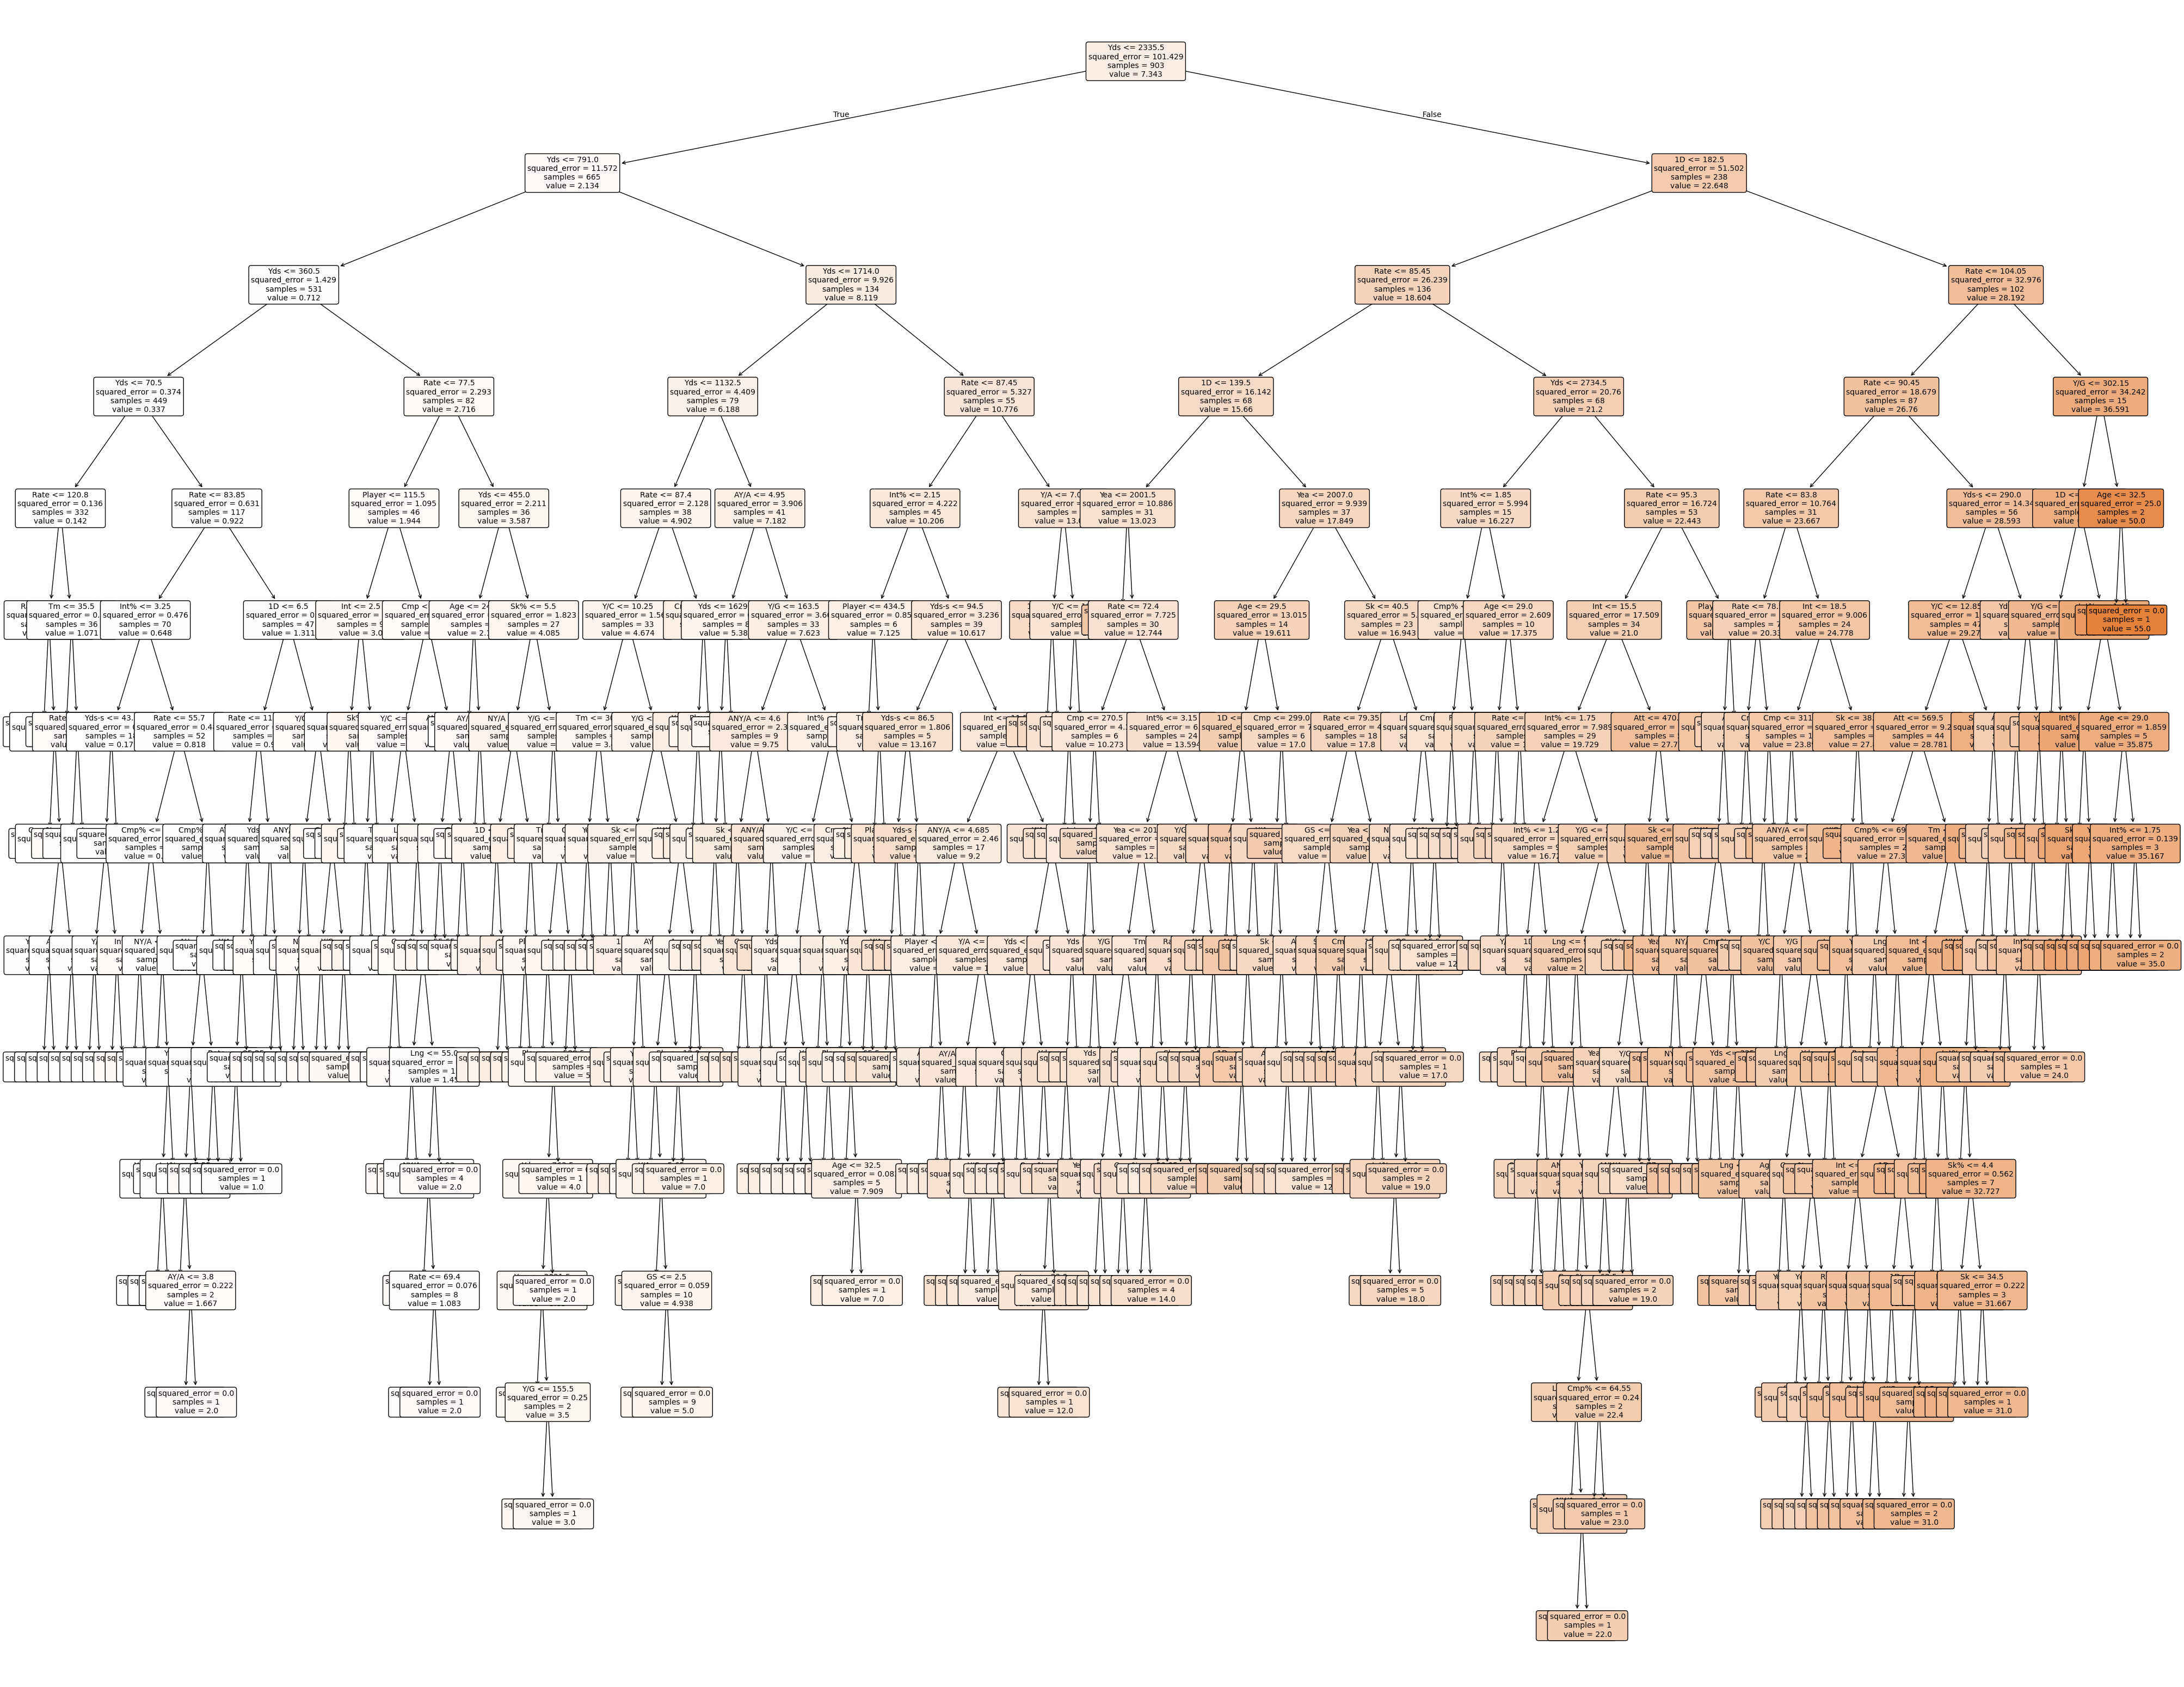

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree_to_plot = clf.estimators_[3]

plt.figure(figsize=(50,40))
plot_tree(tree_to_plot, feature_names=column_names, filled=True, rounded = True, fontsize = 10)
plt.show()

Before using the testing set we want to optimize our scores on the validation set. First we will look at modifying the number of trees in our model (the default is 100).

In [ ]:
number_of_trees = []
oob_scores_tree = []
rmse_tree = []

for i in range(50, 650, 25):
  if i != 100: # computational purposes (already calculated 100)
    number_of_trees.append(i)
    clf = RandomForestRegressor(oob_score=True, n_estimators=i)
    clf.fit(Xtrain, ytrain)
    yval_hat = clf.predict(Xval)
    oob_scores_tree.append(clf.oob_score_)
    rmse_tree.append(root_mean_squared_error(yval, yval_hat))
  else:
    number_of_trees.append(i)
    oob_scores_tree.append(oob_score_def)
    rmse_tree.append(rmse_def)


print(oob_scores_tree)
print(rmse_tree)


[0.9567484020668247, 0.9563813643485354, 0.9584339061392221, 0.9598659224864865, 0.9584792684567452, 0.9594417164226398, 0.9589554068116685, 0.9589586511411785, 0.9589432838697934, 0.9594972114628935, 0.9598035201120848, 0.9592181922692288, 0.9593209324135404, 0.9594369990174144, 0.9597316785640789, 0.959457639846991, 0.9595605566876444, 0.959935172976466, 0.9601442203277117, 0.9597070907334042, 0.9596360898692816, 0.9596736712653168, 0.959753146621258, 0.9597236115194812]
[2.0530162553377043, 2.0474060161089334, 2.0163116738137106, 2.042993314993072, 2.0317329127721506, 2.0481387545267, 2.0308127368963453, 2.011577679249119, 2.030367429277849, 2.0398328075827203, 2.0343038783582816, 2.042364861224075, 2.033593530851006, 2.0410563361592655, 2.028260633352753, 2.0317376090050825, 2.022292348042409, 2.0247138427119653, 2.0289340729408694, 2.0329017012548416, 2.030365139306178, 2.0361466557091323, 2.0338374157168366, 2.0256480381517625]


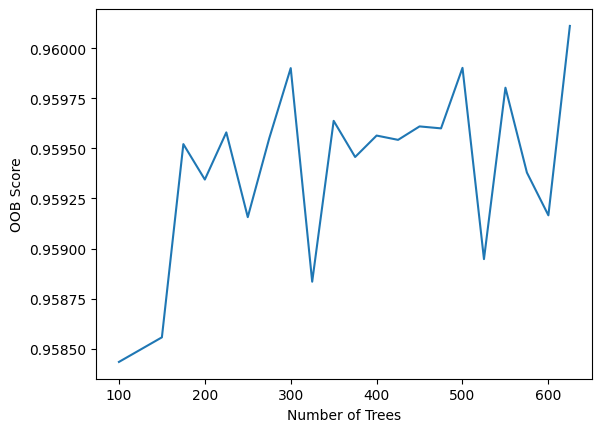

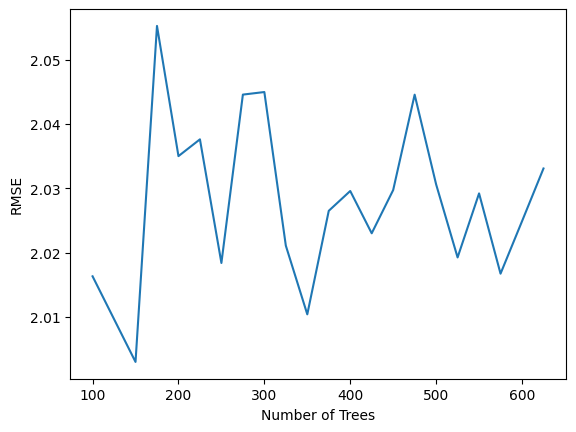

In [ ]:
plt.plot(number_of_trees, oob_scores_tree)
plt.xlabel('Number of Trees')
plt.ylabel('OOB Score')
plt.show()

plt.plot(number_of_trees, rmse_tree)
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.show()


The number of trees has diminishing returns on the model after 200 trees. Increasing the number of trees improves stability, however they become very small after 200. The number of trees that seems like a good balance is 175 trees as its a higher number of trees where we can reduce the computational load while still having low error and high oob score.

As the model is performing well, one of the ways we can reduce the computational costs is by changing the tree depth. This can also help prevent our model from overfitting (The sk learn default is no max tree depth).

In [ ]:
tree_depth = []
oob_scores_depth = []
rmse_depth = []

for i in range(5, 100, 5):
    tree_depth.append(i)
    clf = RandomForestRegressor(oob_score=True, n_estimators=175, max_depth = i)
    clf.fit(Xtrain, ytrain)
    yval_hat = clf.predict(Xval)
    oob_scores_depth.append(clf.oob_score_)
    rmse_depth.append(root_mean_squared_error(yval, yval_hat))

print(oob_scores_depth)
print(rmse_depth)

[0.9538503189381181, 0.9587138440489823, 0.9586629426143782, 0.9597998385735946, 0.9593799419006166, 0.9589349067904138, 0.9592603142778264, 0.9590460288931175, 0.9598959002400218, 0.9594876923241294, 0.959201851500433, 0.9601655786918951, 0.9585342313338344, 0.9586907438426084, 0.9590271924859846, 0.9594850000528229, 0.9588697125596368, 0.9589786883545128, 0.9585856231193992]
[2.1137276222382666, 2.048502046542516, 2.0651524248342845, 2.0365388806121274, 2.0299128575611878, 2.030895077412444, 2.0547439744880007, 2.0300557949505342, 2.017589194357037, 2.0283040193627513, 2.030622602696272, 2.0123287913678407, 2.051250917284909, 2.0223641320464347, 2.020930289688246, 2.0416832302062504, 2.0104657477302, 2.0472398753569183, 2.0379374518740168]


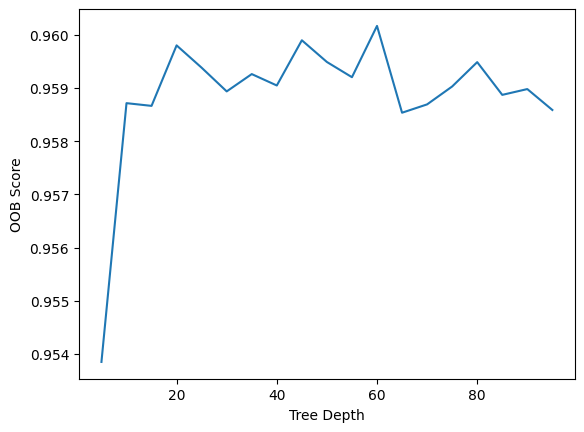

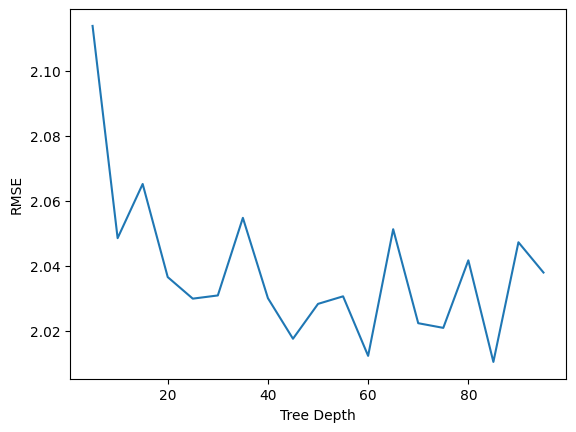

In [ ]:
plt.plot(tree_depth, oob_scores_depth)
plt.xlabel('Tree Depth')
plt.ylabel('OOB Score')
plt.show()

plt.plot(tree_depth, rmse_depth)
plt.xlabel('Tree Depth')
plt.ylabel('RMSE')
plt.show()

As the tree depth increases, the model's RMSE decreases. When looking at the OOB score, a max depth of 20 is a good balance because the oob score starts to level off after it. Also the RMSE doesn't change significantly after increasing the number trees from 20.

Next is the max number of features to split a node. The default in sklearn is the number of features of the dataset. The most common alternatives are using the log2 or sqrt of the number of features.

In [ ]:
feature_split = ['None', 'Sqrt', 'Log2']
oob_scores_feature = []
rmse_feature = []

for i in range(1, 4):
    if i == 1:
      clf = RandomForestRegressor(oob_score=True, n_estimators=175, max_depth = 20)
    elif i == 2:
      clf = RandomForestRegressor(oob_score=True, n_estimators=175, max_depth = 20, max_features = 'sqrt')
    else:
      clf = RandomForestRegressor(oob_score=True, n_estimators=175, max_depth = 20, max_features = 'log2')
    clf.fit(Xtrain, ytrain)
    yval_hat = clf.predict(Xval)
    oob_scores_feature.append(clf.oob_score_)
    rmse_feature.append(root_mean_squared_error(yval, yval_hat))

print(oob_scores_feature)
print(rmse_feature)

[0.9581756750124175, 0.9566668231497044, 0.956674628281682]
[2.029847160824963, 2.095939457949087, 2.1105263261060507]


Because no feature split (looking at all the features when splitting a node) performs the best when regards to RMSE, we will stick with 'None'. Although log2 and sqrt lead to better genearlization, it does not lead to a smaller RMSE. As my goal is to increase the prediction accuracy it makes sense to keep it the same.

The last hyperparameter I want to look at is the criterion or regression penalty. The criterion determines how the trees will split at each node. Whichever feature has the least error at that node will be chosen.

In [ ]:
criterion_split = ['default(mse)', 'Mean Absolute Error', 'friedman_mse', 'poisson']
oob_scores_criterion = []
rmse_criterion = []

for i in range(1, 5):
    if i == 1:
      clf = RandomForestRegressor(oob_score=True, n_estimators=175, max_depth = 20)
    elif i == 2:
      clf = RandomForestRegressor(oob_score=True, n_estimators=175, max_depth = 20, criterion = 'absolute_error')
    elif i == 3:
      clf = RandomForestRegressor(oob_score=True, n_estimators=175, max_depth = 20, criterion = 'friedman_mse')
    else:
      clf = RandomForestRegressor(oob_score=True, n_estimators=175, max_depth = 20, criterion = 'poisson')
    clf.fit(Xtrain, ytrain)
    yval_hat = clf.predict(Xval)
    oob_scores_criterion.append(clf.oob_score_)
    rmse_criterion.append(root_mean_squared_error(yval, yval_hat))

print(criterion_split)
print(oob_scores_criterion)
print(rmse_criterion)

['default(mse)', 'Mean Absolute Error', 'friedman_mse', 'poisson']
[0.959008353521883, 0.9590751373628295, 0.9583552079400839, 0.961146315868826]
[2.0300692958789224, 1.995244406873778, 2.041982870544048, 2.0169854781218537]


The Mean Absolute Error had a lower OOB score than the other errors. This most likely is due to my data having many outliers such as WR throwing touchdowns. We don't want the model to penalize too heavily on outliers, so not squaring the error (like in MSE) can help the model reduce overfitting.

Finally, here is my testing comparison between the default sklearn and my optimized model.

In [ ]:
clf1 = RandomForestRegressor(oob_score=True)
clf2 = RandomForestRegressor(oob_score=True, n_estimators=175, max_depth = 20, criterion = 'absolute_error')

clf1.fit(Xtrain, ytrain)
clf2.fit(Xtrain, ytrain)

# Validation error
yval_hat = clf1.predict(Xval)
my_yval_hat = clf2.predict(Xval)

oob_default_val = clf1.oob_score_
my_oob_val = clf2.oob_score_

rmse_oobdef_val = root_mean_squared_error(yval, yval_hat)
rmse_myoob_val = root_mean_squared_error(yval, my_yval_hat)

print(oob_default_val)
print(my_oob_val)
print(rmse_oobdef_val)
print(rmse_myoob_val)


0.9577576268698003
0.9587755717329227
2.0352308144495814
2.021773794186402


In [ ]:
# Test Error
ytest_hat = clf1.predict(Xtest)
my_ytest_hat = clf2.predict(Xtest)

oob_default_test= clf1.oob_score_
my_oob_test = clf2.oob_score_

rmse_oobdef_test = root_mean_squared_error(ytest, ytest_hat)
rmse_myoob_test = root_mean_squared_error(ytest, my_ytest_hat)

print(oob_default_test)
print(my_oob_test)
print(rmse_oobdef_test)
print(rmse_myoob_test)

0.9577576268698003
0.9587755717329227
1.9936181157607296
1.9637419772443347


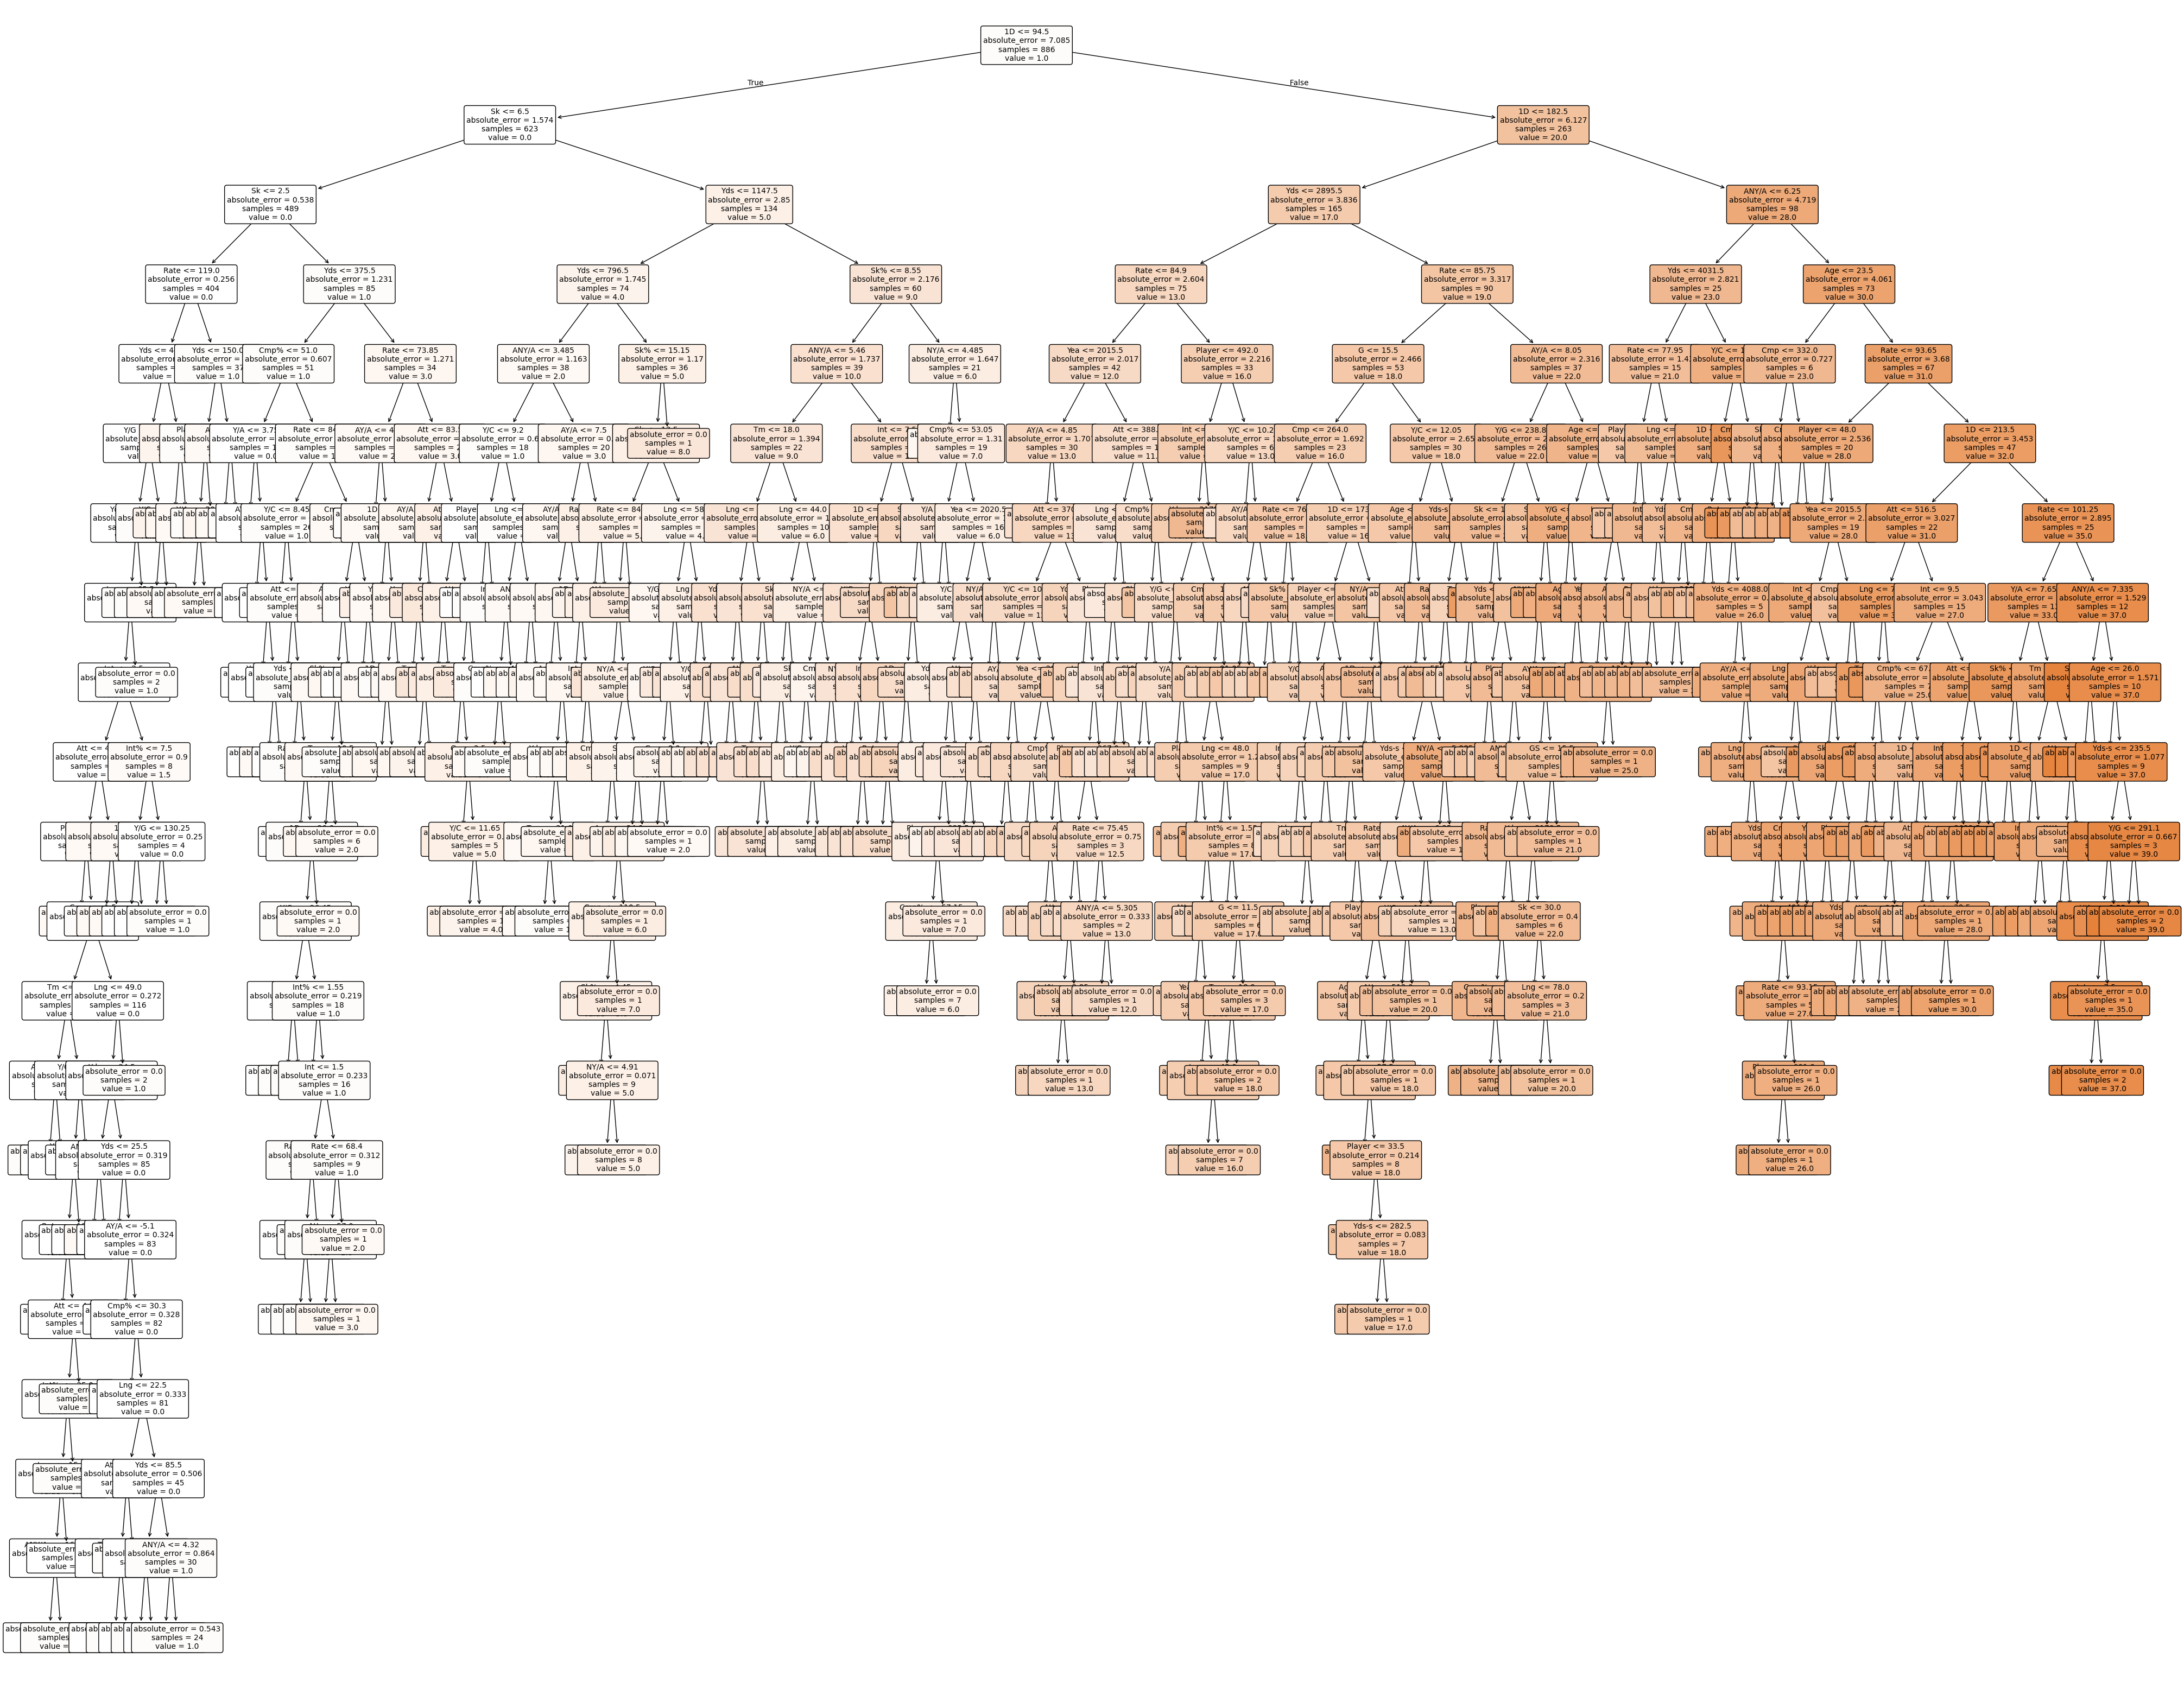

In [ ]:
# Plotting new tree

my_tree = clf2.estimators_[3]

plt.figure(figsize=(50,40))
plot_tree(my_tree, feature_names=column_names, filled=True, rounded = True, fontsize = 10)
plt.show()

As we can see, changing the hyperparameters allowed me to achieve a minor improvement in the accuracy of my prediction in the total number of touchdowns for a given player in a season. The biggest change I observed when training multiple times was 0.07 RMSE improvement with my model. This indicates that the model was already fairly optimized but my improvements can be used to better predict the amount of touchdowns a player will have in a season based on their other stats.